This notebook seeks to ascertain the effet of EHR on controlled drugs (CD). First we will start by looking at relevant OpenPrescribing measures and then focus on overall CD prascribing

In [1]:
##import libraries neededd
import pandas as pd
import numpy as np
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
## ensuring the format is consistent for pounds and pence
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Part 1 OpenPrescribing Measures

As per the DataLab [paper on opioids](https://www.sciencedirect.com/science/article/pii/S2215036618304711) we should focus on measures where an adjustment has been made for tota qunatity.

Releavnt Measures
- https://openprescribing.net/measure/bdzper1000/
- https://openprescribing.net/measure/bdzadq/
- https://openprescribing.net/measure/opioidspercent/
- https://openprescribing.net/measure/opioidper1000/
- https://openprescribing.net/measure/lpfentanylir/
- https://openprescribing.net/measure/lpoxycodone/
- https://openprescribing.net/measure/gabapentinoidsddd/
- https://openprescribing.net/measure/opioidome/
- https://openprescribing.net/measure/pregabalin/
- https://openprescribing.net/measure/pregabalinmg/
    
    
    

In [3]:
import importlib
importlib.reload(bq)
cdmeasures = ['pregabalin', 'bdzadq', 'opioidspercent', 'opioidome', 'pregabalinmg', 'opioidper1000', 'bdzper1000', 'lpfentanylir'
, 'lpoxycodone', 'gabapentinoidsddd']

def get_data(measure_id):
    sql = """
SELECT
  TRIM(Principal_Supplier) AS supplier,
  m.month,
  AVG(IEEE_DIVIDE(numerator, denominator)) AS calc_value,
  '{measure_id}' AS measure_id
FROM
  measures.practice_data_{measure_id} AS m
JOIN
  ebmdatalab.alex.vendors AS software #this is where the up to date vendors table is held
ON
  software.ODS = practice_id
  AND DATE(Date) = m.month
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = practices.code
  AND Date = practice_statistics.month
WHERE
  practices.setting = 4
  AND total_list_size > 100
  AND denominator > 0
GROUP BY
  supplier,
  measure_id,
  m.month
ORDER BY
  m.month""".format(measure_id=measure_id)
    import pandas as pd
    df = bq.cached_read(sql, csv_path="cd_measures.csv".format(measure_id))
    return df


def get_dataframe(cdmeasures):
    df = pd.DataFrame()
    for measure in cdmeasures:
        df = df.append(get_data(measure))
    return df
df = get_dataframe(cdmeasures)

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


In [4]:
# Clean up the input data
import datetime
#df = df.loc[df['month'] > '2016-02-01']  # there is some dirty data ("Unknowns") before this
df = df[(df['supplier'] == 'EMIS') | (df['supplier'] == 'TPP')]
df.month = pd.to_datetime(df['month'])
df = df[df['month'] > '2016-02-01']

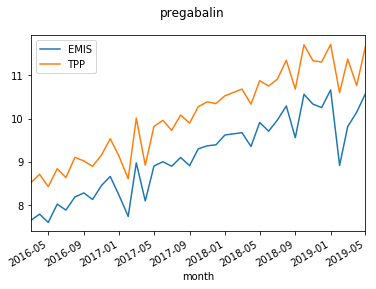

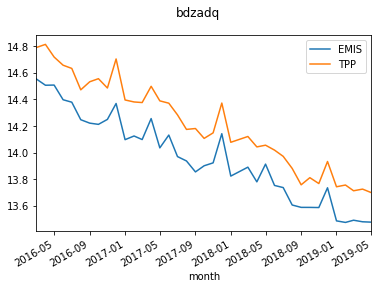

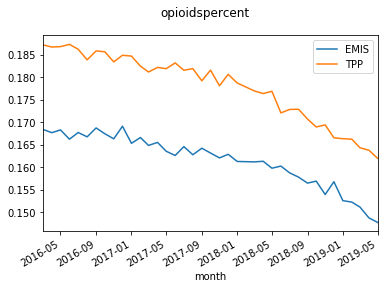

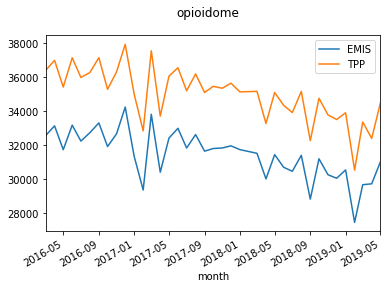

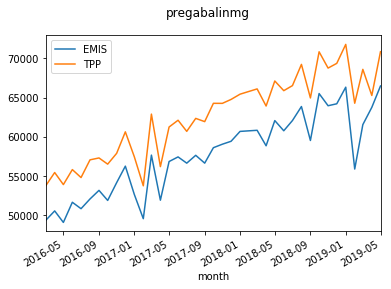

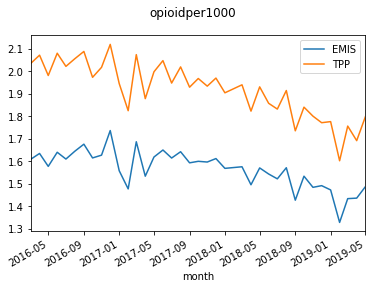

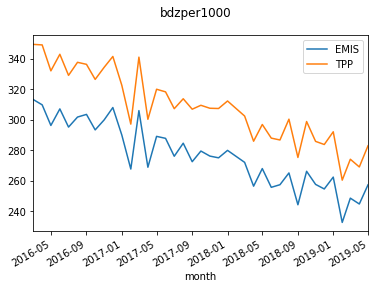

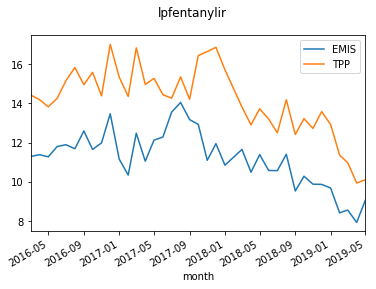

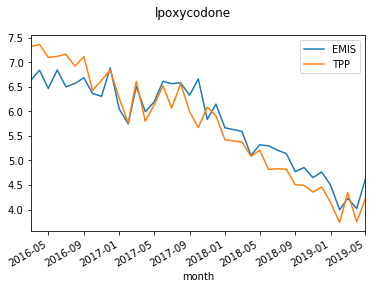

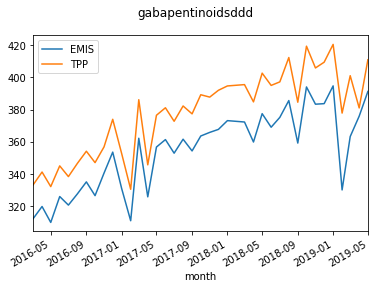

In [5]:
import numpy as np
import matplotlib.pyplot as plt
for measure in cdmeasures:
    fig, ax = plt.subplots()
    df2 = df[df['measure_id'] == measure]
    for key, grp in df2.groupby(['supplier']):
        ax = grp.plot(ax=ax, kind='line', x='month', y='calc_value', label=key)
    fig.suptitle(measure)
    plt.legend(loc='best')
    plt.show()

As Seb investigated before, there appears to be enough difference to continue wth this investigation

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


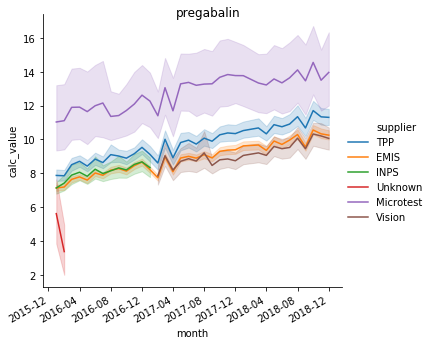

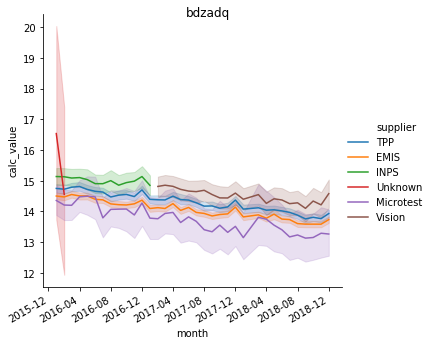

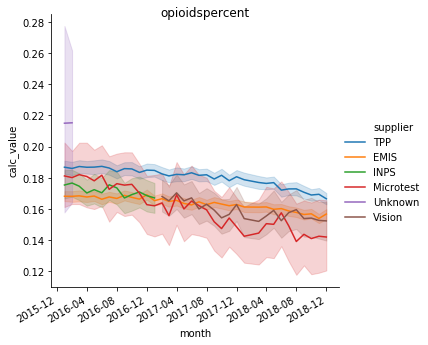

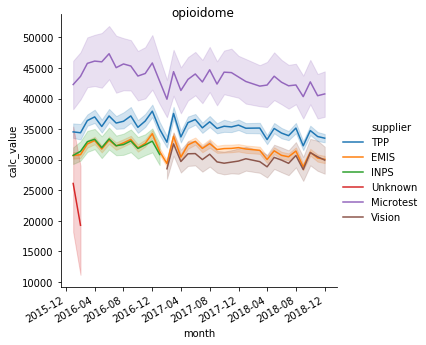

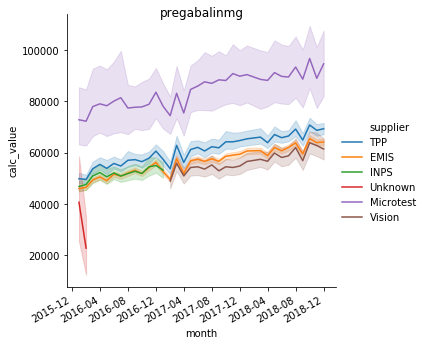

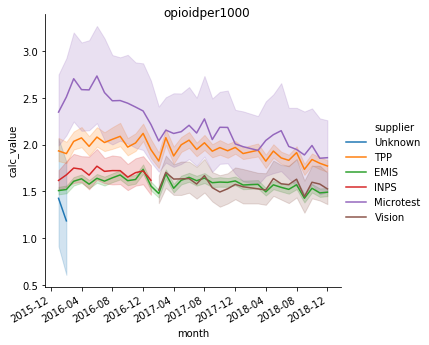

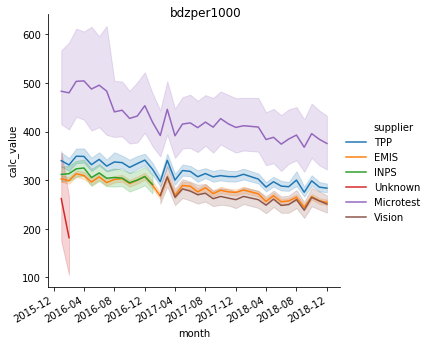

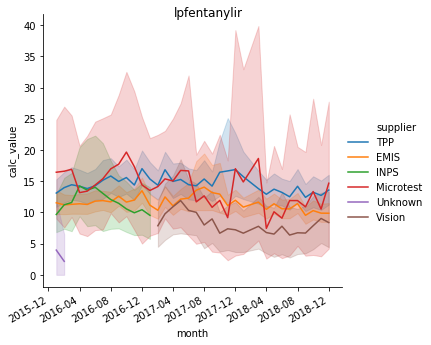

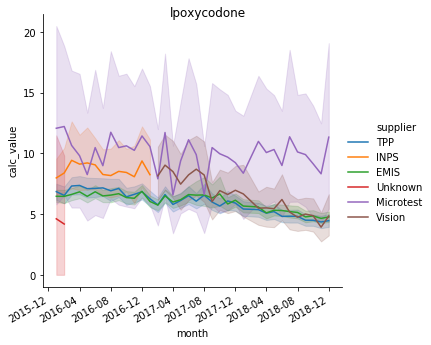

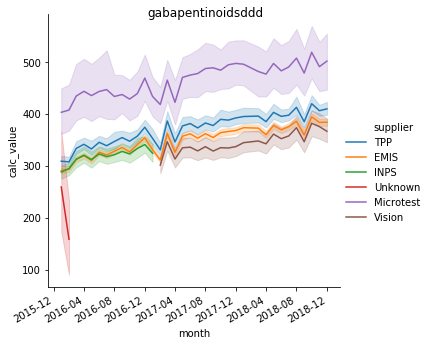

In [6]:
import seaborn as sns
cdmeasuresb = ['pregabalin', 'bdzadq', 'opioidspercent', 'opioidome', 'pregabalinmg', 'opioidper1000', 'bdzper1000', 'lpfentanylir'
, 'lpoxycodone', 'gabapentinoidsddd']

for measure_id in cdmeasuresb:
    sql = """SELECT
  TRIM(Principal_Supplier) AS supplier,
  m.month,
  practice_id,
  IEEE_DIVIDE(numerator, denominator) AS calc_value
FROM
  measures.practice_data_{} m
JOIN
  hscic.vendors software
ON
  software.ODS = practice_id
  AND software.Date = m.month
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = practices.code
  AND Date = DATE(practice_statistics.month)
WHERE
  practices.setting = 4
  AND total_list_size > 100 -- exclude non-standard practices
         ORDER BY
          month""".format(measure_id)
    detailed = bq.cached_read(sql, csv_path="cdball.csv".format(measure_id))
    detailed.month = pd.to_datetime(detailed['month'])

    sns.relplot(x="month", y="calc_value", hue='supplier', kind="line", data=detailed)
    fig = plt.gcf()
    fig.autofmt_xdate()
    fig.suptitle(measure_id) 
    plt.show()

Microtest clouds everything. Lets try again on the three systems TPP, EMIS, Vision

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


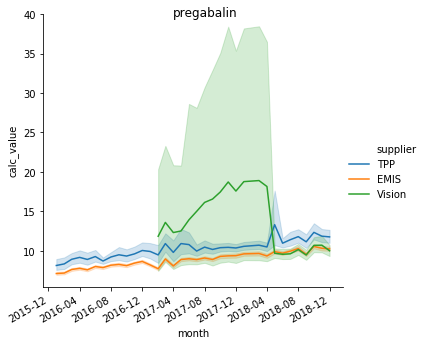

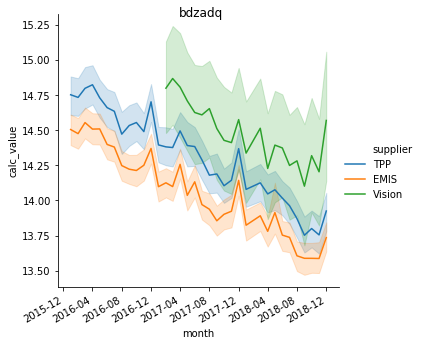

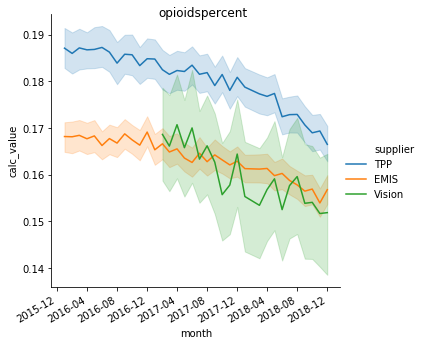

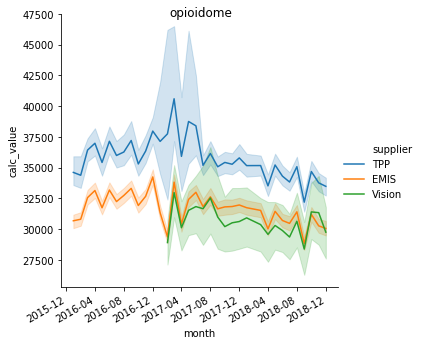

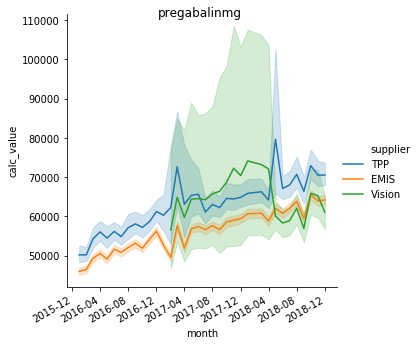

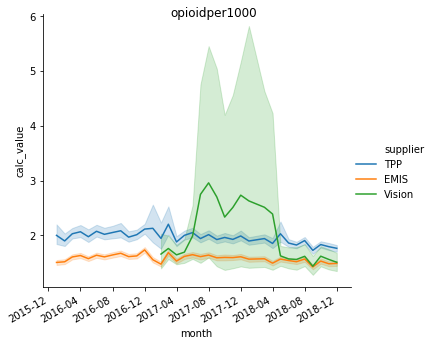

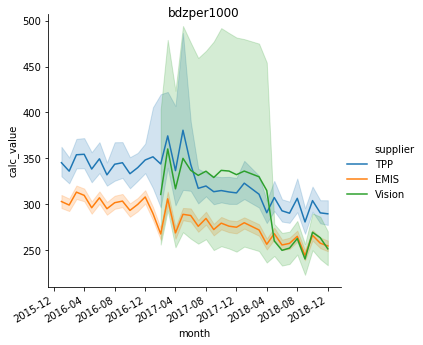

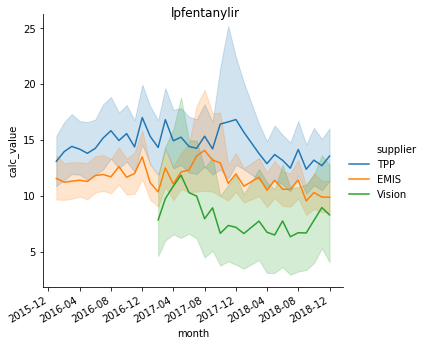

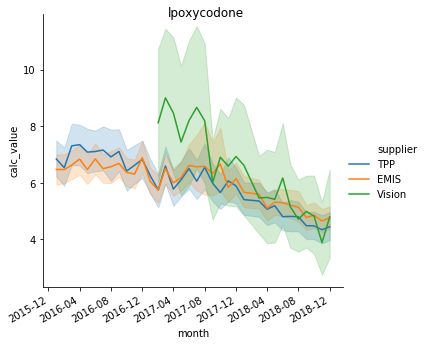

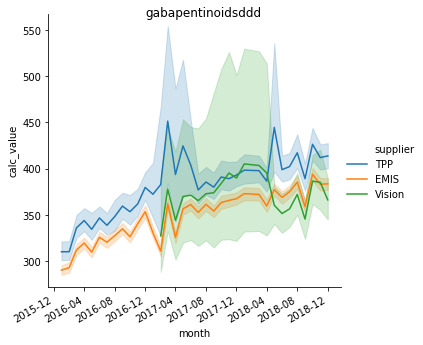

In [7]:
import seaborn as sns
cdmeasuresb = ['pregabalin', 'bdzadq', 'opioidspercent', 'opioidome', 'pregabalinmg', 'opioidper1000', 'bdzper1000', 'lpfentanylir'
, 'lpoxycodone', 'gabapentinoidsddd']

for measure_id in cdmeasuresb:
    sql = """SELECT
  TRIM(Principal_Supplier) AS supplier,
  m.month,
  practice_id,
  IEEE_DIVIDE(numerator, denominator) AS calc_value
FROM
  measures.practice_data_{} m
JOIN
  hscic.vendors software
ON
  software.ODS = practice_id
  AND software.Date = m.month
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = practices.code
  AND Date = DATE(practice_statistics.month)
WHERE
  practices.setting = 4
  AND total_list_size > 100 -- exclude non-standard practices
  AND TRIM(Principal_Supplier) = 'EMIS' OR TRIM(Principal_Supplier) = 'TPP' OR TRIM(Principal_Supplier) = 'Vision'
         ORDER BY
          month""".format(measure_id)
    detailed = bq.cached_read(sql, csv_path="cdbsansmt.csv".format(measure_id))
    detailed.month = pd.to_datetime(detailed['month'])

    sns.relplot(x="month", y="calc_value", hue='supplier', kind="line", data=detailed)
    fig = plt.gcf()
    fig.autofmt_xdate()
    fig.suptitle(measure_id) 
    plt.show()

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


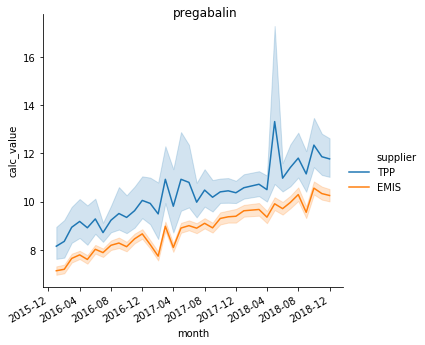

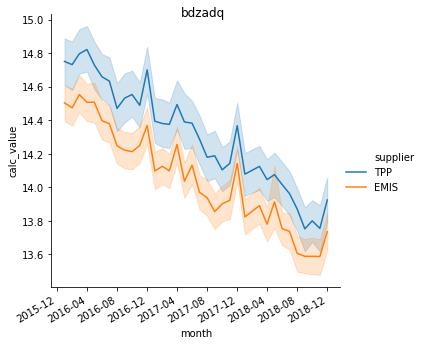

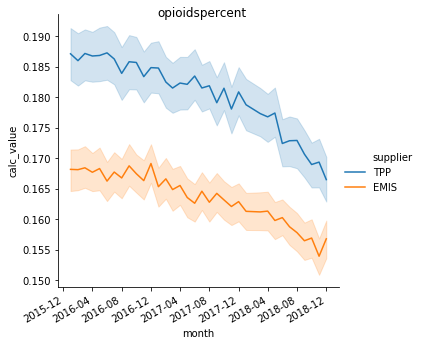

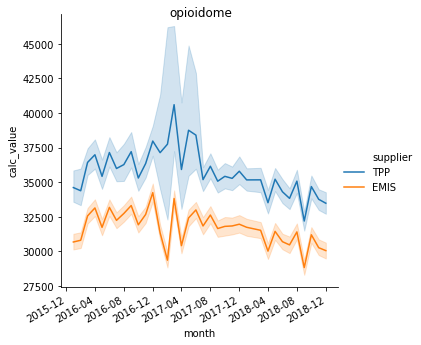

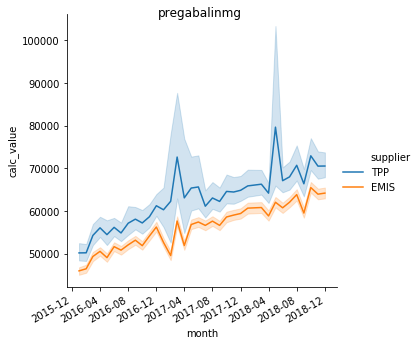

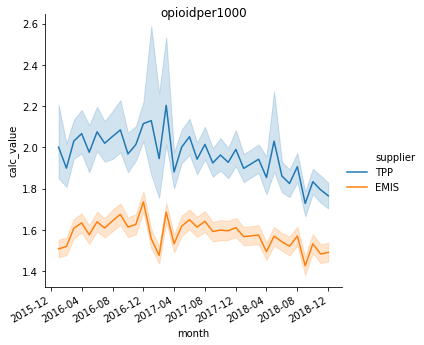

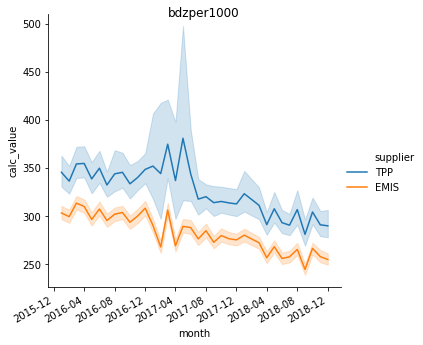

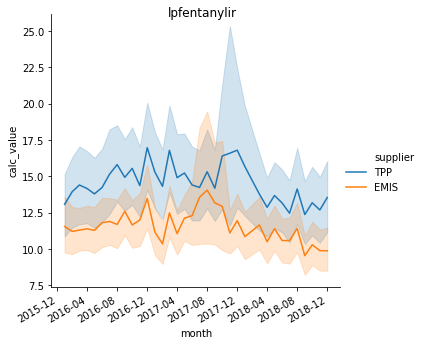

In [ ]:
import seaborn as sns
cdmeasuresb = ['pregabalin', 'bdzadq', 'opioidspercent', 'opioidome', 'pregabalinmg', 'opioidper1000', 'bdzper1000', 'lpfentanylir'
, 'lpoxycodone', 'gabapentinoidsddd']

for measure_id in cdmeasuresb:
    sql = """SELECT
  TRIM(Principal_Supplier) AS supplier,
  m.month,
  practice_id,
  IEEE_DIVIDE(numerator, denominator) AS calc_value
FROM
  measures.practice_data_{} m
JOIN
  hscic.vendors software
ON
  software.ODS = practice_id
  AND software.Date = m.month
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = practices.code
  AND Date = DATE(practice_statistics.month)
WHERE
  practices.setting = 4
  AND total_list_size > 100 -- exclude non-standard practices
  AND TRIM(Principal_Supplier) = 'EMIS' OR TRIM(Principal_Supplier) = 'TPP'
         ORDER BY
          month""".format(measure_id)
    detailed = bq.cached_read(sql, csv_path="cdbemistpp.csv".format(measure_id))
    detailed.month = pd.to_datetime(detailed['month'])

    sns.relplot(x="month", y="calc_value", hue='supplier', kind="line", data=detailed)
    fig = plt.gcf()
    fig.autofmt_xdate()
    fig.suptitle(measure_id) 
    plt.show()

working theory is that when it is an items differnce issue the EHR defaults to a different qty e.g. 28 v 56
when it has been adjusted for qty working thery is that the system presnets a higher stregth product further up the picking list

### now we assess the dmd CD status

##this is table `ebmdatalab.dmd.product` that needs linkage

sql = '''
SELECT
  Date,
  TRIM(Principal_Supplier) AS supplier,
  bnf_name,
  presc.bnf_code,
  vmp.id,
  non_availdt,
  Items,
  actual_Cost
FROM
  ebmdatalab.hscic.prescribing_2019_04 AS presc ##latest month
Inner JOIN
  ebmdatalab.dmd.vmp AS vmp
ON
  presc.bnf_code = vmp.bnf_code
JOIN
  ebmdatalab.alex.vendors AS software #this is where the up to date vendors table is held
ON
  software.ODS = presc.practice
  AND Date = presc.month
WHERE
  non_avail = 1 ###1 = Actual Products not Available
  AND presc.bnf_code != "190203000BBAAA0" ## exclude hompathay that has only one bnf code for all VMPs
GROUP BY
  Date,
  supplier,
  bnf_name,
  presc.bnf_code,
  vmp.id,
  non_avail,
  non_availdt,
  Items,
  actual_Cost
'''



df_unavailable_vmp = bq.cached_read(sql, csv_path='amp_dmd_unavailable_vmp.csv')
df_unavailable_vmp.head(10)